In [1]:
import sys
import os
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import Model, TVModel, LRModel, BLModel
from graph_deep_decoder.architecture import GraphDecoder, GraphDeepDecoder, Ups, Upsampling
from graph_deep_decoder.graph_clustering import MultiResGraphClustering, Type_A

DATASET_PATH = '../dataset/political_blog.npz'
SEED = 0

plt.rcParams['image.cmap'] = 'Spectral_r'

## Load dataset

In [2]:
npzfile = np.load(DATASET_PATH)
A = npzfile['A']
x = npzfile['x']
x = np.where(x == 0, -1, 1)
x = x/np.linalg.norm(x)

G = Graph(A)
L = G.L.todense()
G.set_coordinates()

lambdas, _ = utils.ordered_eig(A)

print('Dir G:', G.is_directed(recompute=True))

Dir G: False


Text(0.5, 1.0, 'Eigenvalues of A')

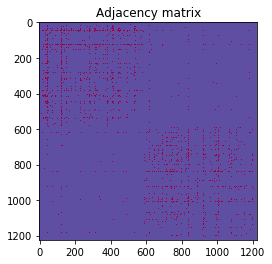

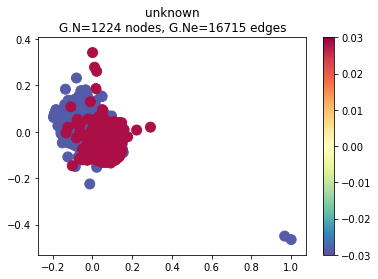

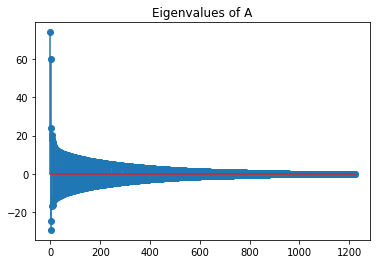

In [3]:
plt.figure()
plt.imshow(A)
plt.title('Adjacency matrix')

G.plot_signal(x)

plt.figure()
plt.stem(lambdas, use_line_collection=True)
plt.title('Eigenvalues of A')

## Characterize dataset

In [4]:
signal = ds.DeterministicGS(G, x)
signal_norm = np.linalg.norm(signal.x)
signal.to_unit_norm()
sm = signal.smoothness()
tv = signal.total_variation()
bl_err_first = signal.check_bl_err(coefs=0.25, firsts=True)
bl_err = signal.check_bl_err(coefs=0.25, firsts=False)

print('SM: {} TV: {} BL Err: {} ({}) N: {}'
      .format(sm, tv, bl_err_first, bl_err, G.N))

SM: 5.147058823529405 TV: 26.909657211314062 BL Err: 0.33231442685156964 (0.1361592800528586) N: 1224


## Missing Values - 20%

## Changing labels - 20%

In [5]:
torch.manual_seed(SEED)
np.random.seed(SEED)

mask = ds.GraphSignal.generate_inpaint_mask(x, 0.2)
# x_n = np.where(mask == 1, x, -x+np.max(x))  # For x in {0,1}
x_n = np.where(mask == 1, x, x*np.sign(x))  # For x in {-1,1}
print('Check labels changed:', np.sum(x_n != x)/G.N)
print('||x-x_n||^2_2 = ', np.sum((x_n-x)**2)/np.linalg.norm(x)**2)

Check labels changed: 0.09068627450980392
||x-x_n||^2_2 =  0.36274509803921556


### Choosing hyperparameters for TV, LR y BL

In [6]:
Exps = [{'type': 'TV', 'alpha': .1, 'legend': 'TV'},
        {'type': 'TV', 'alpha': 1, 'legend': 'TV'},
        {'type': 'TV', 'alpha': 10, 'legend': 'TV'},
        {'type': 'LR', 'alpha': .01, 'legend': 'LR'},
        {'type': 'LR', 'alpha': .1, 'legend': 'LR'},
        {'type': 'LR', 'alpha': 1, 'legend': 'LR'},
        {'type': 'BL', 'alpha': .05, 'legend': 'BL'},
        {'type': 'BL', 'alpha': .15, 'legend': 'BL'},
        {'type': 'BL', 'alpha': .25, 'legend': 'BL'},
        {'type': 'BL', 'alpha': .5, 'legend': 'BL'},
        ]

In [7]:
weights = np.zeros(len(Exps))
err = np.zeros(len(Exps))
bin_err = np.zeros(len(Exps))
start_time = time.time()
for k, exp in enumerate(Exps):
    if exp['type'] is 'TV':
        model = TVModel(A, exp['alpha'])
    elif exp['type'] is 'LR':
        model = LRModel(L, exp['alpha'])
    elif exp['type'] is 'BL':
        _, V = utils.ordered_eig(A)
        k_firsts = int(G.N*exp['alpha'])
        model = BLModel(V, k_firsts)
    else:
        raise Exception('Unkwown exp type')
        
    model.fit(x_n)
    _, err[k] = model.test(x)
    x_bin = np.where(model.x_hat > 0.5, 1, 0)
    bin_err[k] = np.sum((x_bin-x)**2)/np.linalg.norm(x)**2
    print(k, end=' ')

print()
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))


0 1 2 3 4 5 6 7 8 9 

--- 0.11460567315419515 minutes ---


In [8]:
print('Min err:', )
for j in range(len(Exps)):
    print('   Model {}: Err: {}  \tBin Err: {}'.format(j, err[j],
                                                 bin_err[j]))

Min err:
   Model 0: Err: 0.32943189587286925  	Bin Err: 1.0
   Model 1: Err: 0.3321627916006989  	Bin Err: 1.0
   Model 2: Err: 0.6054289252137905  	Bin Err: 1.0
   Model 3: Err: 0.29359407526313475  	Bin Err: 1.0
   Model 4: Err: 0.2932709912411613  	Bin Err: 1.0
   Model 5: Err: 0.6242452972272223  	Bin Err: 1.0
   Model 6: Err: 0.46994200524542246  	Bin Err: 1.0
   Model 7: Err: 0.45904759289561187  	Bin Err: 1.0
   Model 8: Err: 0.45368874050283553  	Bin Err: 1.0
   Model 9: Err: 0.42456120950675247  	Bin Err: 1.0


### Choose best Deep Decoder-U

In [9]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Model parameters
epochs = 1000
lr = 0.001

Exps = [{'type': 'TV', 'alpha': .1, 'legend': 'TV'},
        {'type': 'LR', 'alpha': .25, 'legend': 'LR'},
        {'type': 'BL', 'alpha': .1, 'legend': 'BL'},
    
        # Original
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [24, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        # Upsampling sizes
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [10, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [2, 50, 250] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [2, 150, 500] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        
        # Layers
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [24, 100] + [G.N]*2, 'fts': [62]*3 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [4, 25, 250] + [G.N]*2, 'fts': [62]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [2, 10, 50, 250,] + [G.N]*2, 'fts': [62]*5 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        
        # GF
        {'type': 'DD', 'ups': Ups.GF, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': 3,
         'legend': 'DeepD-U'},
        
        # Weigths
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [24, 50, 150] + [G.N]*2, 'fts': [100]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [24, 50, 150] + [G.N]*2, 'fts': [75]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [24, 50, 150] + [G.N]*2, 'fts': [8]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        
        # Init
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [24, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .01, 'bn': False, 'K': None,
         'legend': 'DeepD-U'},
        ]

for exp in Exps:
    if exp['type'] is 'DD' and exp['ups'] in [Ups.U_MEAN, Ups.GF]:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As


In [10]:
err = np.zeros((len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()

# x /= np.linalg.norm(x)
for j, exp in enumerate(Exps):
    if exp['type'] is 'TV':
        model = TVModel(A, exp['alpha'])
    elif exp['type'] is 'LR':
        model = LRModel(L, exp['alpha'])
    elif exp['type'] is 'BL':
        _, V = utils.ordered_eig(A)
        k = int(G.N*exp['alpha'])
        model = BLModel(V, k)
    elif exp['type'] is '2LD':
        dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
        weights[j] = G.N*exp['fts']
    elif exp['type'] is 'DD':
        dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                               As=exp['As'], act_fn=exp['af'], ups=exp['ups'], K=exp['K'],
                               last_act_fn=exp['laf'], input_std=exp['in_std'],
                               w_std=exp['w_std'])
        weights[j] = dec.count_params()
    else:
        raise Exception('Unkwown exp type')
        
    if exp['type'] in ['DD', '2LD']:
        model = Model(dec, epochs=epochs, learning_rate=lr)
        _, err[j, :], _ = model.fit(x_n, x)
    else:
        model.fit(x_n)
        _, err_non_train = model.test(x)
        err[j, :] = np.repeat(err_non_train, epochs)
    print(j, end=' ')

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 WARNING: degree matrix is singular
3 WARNING: degree matrix is singular
4 5 6 WARNING: degree matrix is singular
7 WARNING: degree matrix is singular
8 9 10 WARNING: degree matrix is singular
11 WARNING: degree matrix is singular
12 WARNING: degree matrix is singular
13 WARNING: degree matrix is singular
14 
--- 1.146469517548879 minutes ---


Min err:
	Model 0: 0.32943189587286925
	Model 10: 0.3673325876889065
	Model 1: 0.37838836937866516
	Model 2: 0.4620439203788343
	Model 3: 0.8912079988185192
	Model 12: 0.9310942370760652
	Model 11: 0.9476032446322482
	Model 14: 0.9570688897250004
	Model 7: 0.9636362546444642
	Model 4: 0.9760055474066784
	Model 13: 0.9812034565265271
	Model 8: 0.9977030871959864
	Model 6: 0.9979075205551449
	Model 5: 0.9998344427440311
	Model 9: 1.000513140349994


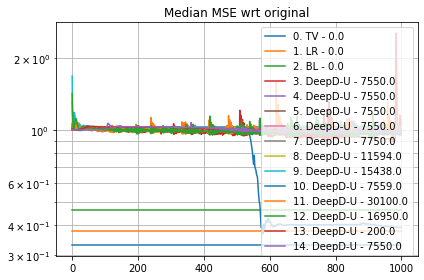

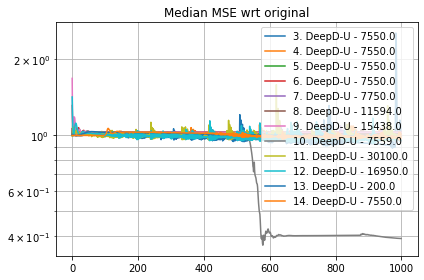

In [11]:
norm_err = err
norm_err[3:] = err[3:]/np.linalg.norm(x)**2 

# Plot results
legend = []
for i, exp in enumerate(Exps):
    legend.append('{}. {} - {}'.format(i, exp['legend'], weights[i]))
    
# Plots Median Error
plt.figure()
plt.semilogy(norm_err.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

plt.figure()
plt.semilogy(norm_err[3:].T)
plt.grid(True, which='both')
plt.legend(legend[3:])
plt.title('Median MSE wrt original')
plt.tight_layout()

print('Min err:', )
min_mse = np.min(norm_err, axis=1)
idx = np.argsort(min_mse)
for i in idx:
    print('\tModel {}: {}'.format(i, min_mse[i]))

## Plot clustering

In [12]:
#plt.figure()
#G.plot_signal(X[:, 31])
#plt.title('Original graph')
#for label in clt.labels[:-2]:
#    plt.figure()
#    G.plot_signal(label)
#    plt.title(str(np.max(label)) + ' clusters')

In [13]:
plt.show()